In [1]:
%pip install pandas fastplot ipython nltk

import pandas as pd
import fastplot
import json
from IPython.display import display

MAX_TOPICS = 8

PLOT_ARGS = {"style":"latex", "grid":True, "figsize":(4.25,2.5), "rcParams":{'text.latex.preamble': '\\usepackage{libertine}\n\\usepackage{setspace}\n\\usepackage{courier}'}, "legend_args":{"columnspacing":1, "handlelength":1.5}}
PLOT_ARGS_LARGE = {"style":"latex", "grid":True, "figsize":(9,3.5), "rcParams":{'text.latex.preamble': '\\usepackage{libertine}\n\\usepackage{setspace}\n\\usepackage{courier}'}, "legend_args":{"columnspacing":1, "handlelength":1.5}}

BEFORE_STR = "\\emph{Before-Accept}"
AFTER_STR = "\\emph{After-Accept}"

JAVASCRIPT_STR = "JavaScript (\\texttt{document.browsingTopics})"
FETCH_STR = "JavaScript (\\texttt{fetch})"
IFRAME_STR = "IFrame"

FIRST_PARTY_STR = "\\emph{First-Party}"
ATTESTED_STR = "\\emph{Attested}"
OTHER_STR = "\\emph{Other}"

%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


In [2]:
def parseJSONDataInDF(df: pd.DataFrame):
    # Convert all JSON data to lists and dicts
    for stage in [ 'first', 'second' ]:
        for field in [ 'allowed_domains', 'attested_domains', 'topics_api_usages' ]:
            df[f"{stage}_{field}"] = df[f"{stage}_{field}"].apply(lambda usages: json.loads(usages))
    for stage in [ 'first', 'second' ]:
        df[f"{stage}_consent_managers"] = df[f"{stage}_consent_managers"].apply(lambda usages: json.loads(usages))
    return df

df = pd.read_csv("analyze-topics-api-output.csv")
df = parseJSONDataInDF(df)
df_clicked = df[df["banner_clicked"]]

In [3]:
def countUsagesPerVisit(df: pd.DataFrame):
    for stage in [ 'first', 'second' ]:
        df[f"{stage}_count_usages"] = df[f"{stage}_topics_api_usages"].apply(lambda usages: len(usages))
    return df

def getDomain(url: str):
    return url.split("//")[1][:-1]

bad_domains=set("co.uk co.jp co.hu co.il com.au co.ve .co.in com.ec com.pk co.th co.nz com.br com.sg com.sa \
com.do co.za com.hk com.mx com.ly com.ua com.eg com.pe com.tr co.kr com.ng com.pe com.pk co.th \
com.au com.ph com.my com.tw com.ec com.kw co.in co.id com.com com.vn com.bd com.ar \
com.co com.vn org.uk net.gr".split())

def getGoodTLD(fqdn):
    if fqdn[-1] == ".":
        fqdn = fqdn[:-1]
    names = fqdn.split(".")
    if ".".join(names[-2:]) in bad_domains:
        return "." + ".".join(names[-2:])
    else:
        return "." + names[-1]

def getGood2LD(fqdn):
    if fqdn[-1] == ".":
        fqdn = fqdn[:-1]
    names = fqdn.split(".")
    if ".".join(names[-2:]) in bad_domains:
        return get3LD(fqdn)
    tln_array = names[-2:]
    tln = ""
    for s in tln_array:
        tln = tln + "." + s
    return tln[1:]

def get3LD(fqdn):
    if fqdn[-1] == ".":
        fqdn = fqdn[:-1]
    names = fqdn.split(".")
    tln_array = names[-3:]
    tln = ""
    for s in tln_array:
        tln = tln + "." + s
    return tln[1:]

df_count_usages = countUsagesPerVisit(df)
df_count_usages_clicked = countUsagesPerVisit(df_clicked)

/tmp/ipykernel_11468/624921945.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{stage}_count_usages"] = df[f"{stage}_topics_api_usages"].apply(lambda usages: len(usages))
/tmp/ipykernel_11468/624921945.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{stage}_count_usages"] = df[f"{stage}_topics_api_usages"].apply(lambda usages: len(usages))


In [4]:
total_fps = len(df_clicked)
fps_with_usages_first = len(df_count_usages_clicked[df_count_usages_clicked["first_count_usages"] > 0])
fps_with_usages_second = len(df_count_usages_clicked[df_count_usages_clicked["second_count_usages"] > 0])

display(f"First parties with usages on the first visit: {fps_with_usages_first} [{100*fps_with_usages_first/total_fps}]")
display(f"First parties with usages on the second visit: {fps_with_usages_second} [{100*fps_with_usages_second/total_fps}]")

'First parties with usages on the first visit: 1052 [7.147224675589374]'

'First parties with usages on the second visit: 6593 [44.79244513893607]'

# Count Third Parties

In [5]:
# TOTAL DOMAINS
with open("contacted_domains.txt", "r") as file:
    total_domains = [ line[:-1] for line in file.readlines() ]
    display(f"Total unique (2nd level) domains: {len(total_domains)}")

df_usages_first = df.explode("first_topics_api_usages")
df_usages_first = df_usages_first[~df_usages_first["first_topics_api_usages"].isna()]
df_usages_first["usage_context_domain"] = df_usages_first["first_topics_api_usages"].apply(lambda usage: getGood2LD(getDomain(usage["context_origin_url"])))
callers_first = df_usages_first["usage_context_domain"].drop_duplicates()
display(f"Callers during first visit: {len(callers_first)}")

df_usages_second = df_clicked.explode("second_topics_api_usages")
df_usages_second = df_usages_second[~df_usages_second["second_topics_api_usages"].isna()]
df_usages_second["usage_context_domain"] = df_usages_second["second_topics_api_usages"].apply(lambda usage: getGood2LD(getDomain(usage["context_origin_url"])))
callers_second = df_usages_second["usage_context_domain"].drop_duplicates()
display(f"Callers during second visit: {len(callers_second)}")

df_attested_first = df.explode("first_attested_domains")
df_attested_first = df_attested_first[~df_attested_first["first_attested_domains"].isna()]
attested_first = df_attested_first["first_attested_domains"].drop_duplicates()
display(f"Attested domains in first visit: {len(attested_first)}")

df_attested_second = df.explode("second_attested_domains")
df_attested_second = df_attested_second[~df_attested_second["second_attested_domains"].isna()]
attested_second = df_attested_second["second_attested_domains"].drop_duplicates()
display(f"Attested domains in second visit: {len(attested_second)}")

df_allowed_first = df.explode("first_allowed_domains")
df_allowed_first = df_allowed_first[~df_allowed_first["first_allowed_domains"].isna()]
allowed_first = df_allowed_first["first_allowed_domains"].drop_duplicates()
display(f"Allowed domains in first visit: {len(allowed_first)}")

df_allowed_second = df.explode("second_allowed_domains")
df_allowed_second = df_allowed_second[~df_allowed_second["second_allowed_domains"].isna()]
allowed_second = df_allowed_second["second_allowed_domains"].drop_duplicates()
display(f"Allowed domains in second visit: {len(allowed_second)}")

not_callers_first = set(total_domains)

# INTERSECTIONS
callers_attested_allowed_first = list(set(callers_first) & set(attested_first) & set(allowed_first))
display(f"callers, attested, allowed in first visit: {len(callers_attested_allowed_first)}")

callers_attested_allowed_second = list((set(callers_second) & set(attested_second)) & set(allowed_second))
display(f"callers, attested, allowed in second visit: {len(callers_attested_allowed_second)}")

callers_attested_not_allowed_first = list((set(callers_first) & set(attested_first)) - set(allowed_first))
display(f"callers, attested, !allowed in first visit: {len(callers_attested_not_allowed_first)} ({next(iter(callers_attested_not_allowed_first))})")

callers_attested_not_allowed_second = list((set(callers_second) & set(attested_second)) - set(allowed_second))
display(f"callers, attested, !allowed in second visit: {len(callers_attested_not_allowed_second)} ({next(iter(callers_attested_not_allowed_second))})")

callers_not_attested_allowed_first = list(set(callers_first) - set(allowed_first) - set(attested_first))
display(f"callers, !attested, !allowed in first visit: {len(callers_not_attested_allowed_first)}")

callers_not_attested_allowed_second = list(set(callers_second) - set(allowed_second) - set(attested_second))
display(f"callers, !attested, !allowed in second visit: {len(callers_not_attested_allowed_second)}")

not_callers_attested_allowed_first = list((set(total_domains) & set(allowed_first) & set(attested_first)) - set(callers_first))
display(f"!callers, attested, allowed in first visit: {len(not_callers_attested_allowed_first)}")

not_callers_attested_allowed_second = list((set(total_domains) & set(allowed_second) & set(attested_second)) - set(callers_second))
display(f"!callers, attested, allowed in second visit: {len(not_callers_attested_allowed_second)}")

not_callers_not_attested_allowed_first = list((set(total_domains) & set(allowed_first)) - set(attested_first) - set(callers_first))
display(f"!callers, !attested, allowed in first visit: {len(not_callers_not_attested_allowed_first)}")

not_callers_not_attested_allowed_second = list((set(total_domains) & set(allowed_second)) - set(attested_second) - set(callers_second))
display(f"!callers, !attested, allowed in second visit: {len(not_callers_not_attested_allowed_first)}")

not_callers_not_attested_allowed_first = list((set(total_domains) & set(allowed_first)) - set(attested_first) - set(callers_first))
display(f"!callers, !attested, allowed in first visit: {len(not_callers_not_attested_allowed_first)}")

not_callers_not_attested_allowed_second = list((set(total_domains) & set(allowed_second)) - set(attested_second) - set(callers_second))
display(f"!callers, !attested, allowed in second visit: {len(not_callers_not_attested_allowed_second)}")

not_callers_attested_not_allowed_first = list((set(total_domains) & set(allowed_first)) - set(attested_first) - set(callers_first))
display(f"!callers, attested, !allowed in first visit: {len(not_callers_attested_not_allowed_first)}")

not_callers_attested_not_allowed_second = list((set(total_domains) & set(allowed_second)) - set(attested_second) - set(callers_second))
display(f"!callers, attested, !allowed in second visit: {len(not_callers_attested_not_allowed_second)}")

not_callers_not_attested_not_allowed_first = list((set(total_domains)) - set(allowed_first) - set(attested_first) - set(callers_first))
display(f"!callers, !attested, !allowed in first visit: {len(not_callers_not_attested_not_allowed_first)}")

not_callers_not_attested_not_allowed_second = list((set(total_domains)) - set(allowed_second) - set(attested_second) - set(callers_second))
display(f"!callers, !attested, !allowed in second visit: {len(not_callers_not_attested_not_allowed_second)}")

'Total unique (2nd level) domains: 62939'

'Callers during first visit: 1337'

'Callers during second visit: 2662'

'Attested domains in first visit: 165'

'Attested domains in second visit: 164'

'Allowed domains in first visit: 149'

'Allowed domains in second visit: 149'

'callers, attested, allowed in first visit: 28'

'callers, attested, allowed in second visit: 47'

'callers, attested, !allowed in first visit: 1 (tail.digital)'

'callers, attested, !allowed in second visit: 1 (dstillery.com)'

'callers, !attested, !allowed in first visit: 1308'

'callers, !attested, !allowed in second visit: 2614'

'!callers, attested, allowed in first visit: 121'

'!callers, attested, allowed in second visit: 102'

'!callers, !attested, allowed in first visit: 0'

'!callers, !attested, allowed in second visit: 0'

'!callers, !attested, allowed in first visit: 0'

'!callers, !attested, allowed in second visit: 0'

'!callers, attested, !allowed in first visit: 0'

'!callers, attested, !allowed in second visit: 0'

'!callers, !attested, !allowed in first visit: 61466'

'!callers, !attested, !allowed in second visit: 60161'

# Legitimate usage

<Figure size 640x480 with 0 Axes>

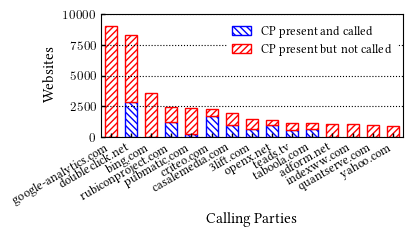

<Figure size 640x480 with 0 Axes>

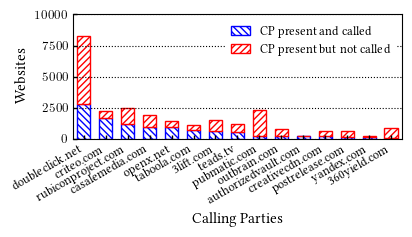

In [6]:
df_third_parties_present = df_clicked.explode("second_allowed_domains")
df_third_parties_present = df_third_parties_present.loc[~df_third_parties_present[f"second_allowed_domains"].isna()]
df_count_allowed = df_third_parties_present[[ "domain", "second_allowed_domains" ]].drop_duplicates()["second_allowed_domains"].value_counts().reset_index().rename(columns = { "second_allowed_domains": "third_party" }).set_index("third_party")

df_third_parties_usage = df_clicked.explode("second_topics_api_usages")
df_third_parties_usage = df_third_parties_usage.loc[~df_third_parties_usage[f"second_topics_api_usages"].isna()]
df_third_parties_usage["usage_context_domain"] = df_third_parties_usage["second_topics_api_usages"].apply(lambda usage: getGood2LD(getDomain(usage["context_origin_url"])))
df_count_usages = df_third_parties_usage[[ "domain", "usage_context_domain" ]].drop_duplicates()["usage_context_domain"].value_counts().reset_index().rename(columns = { "usage_context_domain": "third_party" }).set_index("third_party")

df_third_parties_count = df_count_usages.join(df_count_allowed, how="right", lsuffix="_usages", rsuffix="_allowed").fillna(0)

# Count and calculate percentage of all first parties where each third party is called
for sort_by in [ "allowed", "usages" ]:
    df_plot = df_third_parties_count.sort_values(f"count_{sort_by}", ascending=False).head(15)
    df_plot["count_allowed"] = df_plot.apply(lambda row: row["count_allowed"] - row["count_usages"], axis=1)
    df_plot = df_plot.rename(columns={ "count_allowed": "CP present but not called", "count_usages": "CP present and called" }) 

    plot = fastplot.plot(
        df_plot,
        path=None,
        mode='bars_stacked',
        xlabel='Calling Parties', xticks_fontsize="small", xticks_rotate = 30,
        ylabel='Websites', yticks_fontsize="small",
        legend = True, legend_loc='upper right', legend_ncol=1, legend_alpha=1, legend_fontsize="small",
        grid_axis="y",
        **PLOT_ARGS
    )

    for p in plot.gca().patches[:len(df_plot)] + [plot.gca().get_legend().get_patches()[0]]:
        p.set_hatch("\\\\\\\\\\")
        p.set_edgecolor ("blue")
        p.set_facecolor ("white")
    for p in plot.gca().patches[len(df_plot):] + [plot.gca().get_legend().get_patches()[1]]:
        p.set_hatch("/////")
        p.set_edgecolor ("red")
        p.set_facecolor ("white")

    plot.savefig(f"plots/01_priv-accept-top-third-parties-total-sort-by-{sort_by}.pdf")
    plot.show()

<Figure size 640x480 with 0 Axes>

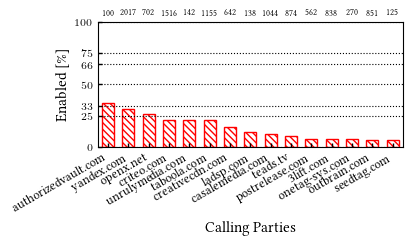

<Figure size 640x480 with 0 Axes>

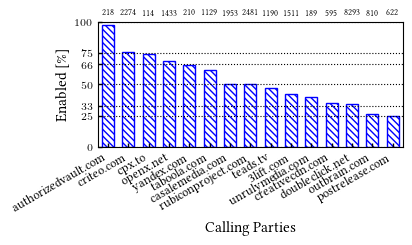

In [7]:
for dataset,stage,dsName,color in [ (df,"first","DSba","red"), (df_clicked,"second", "DSaa","blue") ]:
    df_third_parties_present = dataset.explode(f"{stage}_allowed_domains")
    df_third_parties_present = df_third_parties_present[~df_third_parties_present[f"{stage}_allowed_domains"].isna()]
    df_count_allowed = df_third_parties_present[[ "domain", f"{stage}_allowed_domains" ]].drop_duplicates()
    df_count_allowed = df_count_allowed[f"{stage}_allowed_domains"].value_counts().to_frame()

    df_third_parties_usages = dataset.explode(f"{stage}_topics_api_usages")
    df_third_parties_usages = df_third_parties_usages[~df_third_parties_usages[f"{stage}_topics_api_usages"].isna()]
    df_third_parties_usages["usage_context_domain"] = df_third_parties_usages[f"{stage}_topics_api_usages"].apply(lambda usage: getGood2LD(getDomain(usage["context_origin_url"])))
    df_third_parties_usages = df_third_parties_usages[[ "domain", "usage_context_domain" ]].drop_duplicates()
    df_count_usages = df_third_parties_usages["usage_context_domain"].value_counts().to_frame()

    # Join counts
    df_third_parties_count = df_count_allowed.join(df_count_usages, how="left", lsuffix="_allowed", rsuffix="_usage").fillna(0)

    # Consider only third parties that appear in at least 100 first parties
    df_third_parties_count = df_third_parties_count[df_third_parties_count["count_allowed"] >= 100]

    # Calculate percentage based on counts
    df_third_parties_count["percentage"] = df_third_parties_count.apply(lambda row: row["count_usage"] * 100 / row["count_allowed"], axis=1)

    df_third_parties_count_top = df_third_parties_count.sort_values("percentage", ascending=False).head(15)
    plot_data = [
        (tp,count) for tp,count in df_third_parties_count_top[[ "percentage" ]].itertuples(index=True)
    ]

    plot = fastplot.plot(
        plot_data,
        path=None,
        mode='bars',
        xlabel='Calling Parties', xticks_fontsize="small", xticks_rotate = 30,
        ylabel='Enabled [\\%]', yticks=([0,25,33,50,66,75,100], None), yticks_fontsize="x-small",
        grid_axis="y",
        **PLOT_ARGS
    )

    # plot.text(7, 120, "First parties where third party is present", ha="center")
    
    for i, count in enumerate(df_third_parties_count_top["count_allowed"]):
        plot.text(i, 105, int(count), ha="center", size="xx-small")

    for p in plot.gca().patches[:len(plot_data)]: # + [plot.gca().get_legend().get_patches()[0]]:
        p.set_hatch("\\\\\\\\\\")
        p.set_edgecolor (color)
        p.set_facecolor ("white")

    # plot.subplots_adjust(left=0.22, bottom=0.38, right=0.95, top=0.9)

    plot.savefig(f"plots/02_priv-accept-top-third-party-call-rates-{dsName}.pdf")
    plot.show()

# Questionable usage

/tmp/ipykernel_11468/3641660165.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_third_parties_count["usage_context_domain"] = df_third_parties_count["first_topics_api_usages"].apply(lambda usage: getGood2LD(getDomain(usage["context_origin_url"])))


<Figure size 640x480 with 0 Axes>

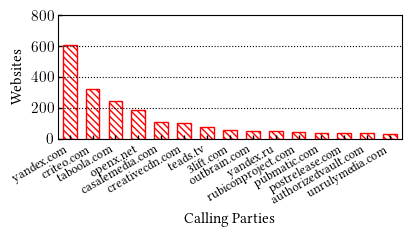

In [8]:
df_third_parties = df.explode("first_topics_api_usages")

# Filter rows where there are attested domains
df_third_parties_count = df_third_parties.loc[~df_third_parties["first_topics_api_usages"].isna()]

# Compute level 2 domains from the context origins (usages only)
df_third_parties_count["usage_context_domain"] = df_third_parties_count["first_topics_api_usages"].apply(lambda usage: getGood2LD(getDomain(usage["context_origin_url"])))

df_third_parties_count = df_third_parties_count[["domain", "usage_context_domain"]].drop_duplicates().value_counts("usage_context_domain").to_frame().head(15)

plot_data = [
    (fp,tp) for fp,tp in df_third_parties_count.itertuples(index=True)
]

plot = fastplot.plot(
    plot_data,
    path=None,
    mode='bars',
    xlabel='Calling Parties', xticks_fontsize="small", xticks_rotate = 30,
    ylabel='Websites',
    grid_axis="y",
    **PLOT_ARGS
)

for p in plot.gca().patches[:len(plot_data)]: # + [plot.gca().get_legend().get_patches()[0]]:
    p.set_hatch("\\\\\\\\\\")
    p.set_edgecolor ("red")
    p.set_facecolor ("white")

plot.savefig("plots/03_priv-accept-top-tp-by-number-of-fp-in-first.pdf")
plot.show()

30

<Figure size 640x480 with 0 Axes>

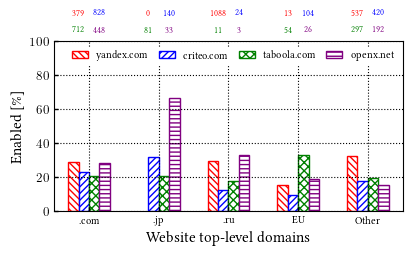

In [9]:
THIRD_PARTIES = [ "yandex.com", "criteo.com", "taboola.com", "openx.net" ]

DOMAIN_GROUPS = {
    "EU": [ ".eu", ".at", ".be", ".bg", ".cy", ".cz", ".de", ".dk", ".es", ".fi", ".fr", ".ee", ".hr", ".hu", ".gr", ".ie", ".it", ".lt", ".lv", ".lu", ".mt", ".nl", ".pl", ".pt", ".ro", ".sk", ".si", ".se", ".uk", ".co.uk" ],
    ".com": [ ".com" ],
    ".ru": [ ".ru" ],
    ".jp": [ ".co.jp", ".jp" ]
}

display(len(DOMAIN_GROUPS["EU"]))

def get_domain_group(tld):
    for group, group_tlds in DOMAIN_GROUPS.items():
        if tld in group_tlds:
            return group
    return "Other"

df_tld = df
df_tld["tld"] = df_tld["domain"].apply(lambda domain: getGoodTLD(getDomain(domain)))
df_tld["domain_group"] = df_tld["tld"].apply(get_domain_group)

df_third_parties_allowed = df_tld.explode("first_allowed_domains")
df_third_parties_allowed = df_third_parties_allowed[~df_third_parties_allowed["first_allowed_domains"].isna()]
df_count_allowed_by_domain_group = df_third_parties_allowed[[ "domain", "domain_group", "first_allowed_domains" ]].drop_duplicates()
df_count_allowed_by_domain_group = df_count_allowed_by_domain_group[[ "domain_group", "first_allowed_domains" ]].value_counts().to_frame().rename_axis([ "domain_group", "third_party" ])

df_third_parties_usages = df_tld.explode("first_topics_api_usages")
df_third_parties_usages = df_third_parties_usages[~df_third_parties_usages["first_topics_api_usages"].isna()]
df_third_parties_usages["usage_context_domain"] = df_third_parties_usages["first_topics_api_usages"].apply(lambda usage: getGood2LD(getDomain(usage["context_origin_url"])))
df_count_usages_by_domain_group = df_third_parties_usages[[ "domain", "domain_group", "usage_context_domain" ]].drop_duplicates()
df_count_usages_by_domain_group = df_third_parties_usages[[ "domain_group", "usage_context_domain" ]].value_counts().to_frame().rename_axis([ "domain_group", "third_party" ])

# Join counts
df_usage_allowed_counts = df_count_allowed_by_domain_group.join(df_count_usages_by_domain_group, how="left", lsuffix="_allowed", rsuffix="_usage").fillna(0).reset_index()
df_usage_allowed_counts["percentage"] = df_usage_allowed_counts.apply(lambda row: row["count_usage"] * 100 / row["count_allowed"], axis=1)

df_usage_allowed_counts_top = df_usage_allowed_counts.sort_values("percentage", ascending=False)

df_plot = df_usage_allowed_counts_top.pivot_table("percentage", "domain_group", "third_party").reindex(THIRD_PARTIES, axis=1)
plot = fastplot.plot(
    df_plot,
    path=None,
    mode='bars_multi',
    xlabel='Website top-level domains', xticks_fontsize="x-small", #xticks_rotate=30,
    ylabel='Enabled [\\%]', yticks_fontsize="small", ylim=(0,100),
    legend = True, legend_loc='upper right', legend_ncol=4, legend_alpha=1, legend_fontsize="x-small",
    # grid_axis="y",
    **PLOT_ARGS
)

# plot.text(len(df_plot)/2-.5, 130, "First parties (under TLD) where the third party is present", ha="center")

if len(THIRD_PARTIES) > 3:
    y_start = 105
    for i, tp, color in zip(range(len(THIRD_PARTIES)), THIRD_PARTIES, [ "red", "blue", "green", "purple" ]):
        domain_groups = df_usage_allowed_counts_top["domain_group"].drop_duplicates().sort_values()
        for j,domain_group in enumerate(domain_groups):
            count = df_usage_allowed_counts_top.loc[df_usage_allowed_counts_top["domain_group"] == domain_group].loc[df_usage_allowed_counts_top["third_party"] == tp]
            if not count.empty:
                count = count["count_allowed"].iloc[0]
            else:
                count = 0
            x = j + (-1 if i%2 == 0 else 1)*.15
            y = 115 - 5 * (i-1 if i%2 == 1 else i)
            plot.text(x, y, int(count), ha="center", size="xx-small", color=color)
else:
    for i, tp, color in zip(range(len(THIRD_PARTIES)), THIRD_PARTIES, [ "red", "blue", "green" ]):
        domain_groups = df_usage_allowed_counts_top["domain_group"].drop_duplicates().sort_values()
        for j,domain_group in enumerate(domain_groups):
            count = df_usage_allowed_counts_top.loc[df_usage_allowed_counts_top["domain_group"] == domain_group].loc[df_usage_allowed_counts_top["third_party"] == tp]
            if not count.empty:
                count = count["count_allowed"].iloc[0]
            else:
                count = 0
            x = j
            y = 120 - 7*i
            plot.text(x, y, int(count), ha="center", size="xx-small", color=color)

for p in plot.gca().patches[:len(df_plot)] + [plot.gca().get_legend().get_patches()[0]]:
    p.set_hatch("\\\\\\\\\\")
    p.set_edgecolor ("red")
    p.set_facecolor ("white")
for p in plot.gca().patches[len(df_plot):2*len(df_plot)] + [plot.gca().get_legend().get_patches()[1]]:
    p.set_hatch("/////")
    p.set_edgecolor ("blue")
    p.set_facecolor ("white")
for p in plot.gca().patches[2*len(df_plot):3*len(df_plot)] + [plot.gca().get_legend().get_patches()[2]]:
    p.set_hatch("xxxx")
    p.set_edgecolor ("green")
    p.set_facecolor ("white")
if len(THIRD_PARTIES) > 3:
    for p in plot.gca().patches[3*len(df_plot):] + [plot.gca().get_legend().get_patches()[3]]:
        p.set_hatch("----")
        p.set_edgecolor ("purple")
        p.set_facecolor ("white")

plot.subplots_adjust(left=0.13, bottom=0.17, right=0.95, top=0.85)

plot.savefig(f"plots/04_top-level-domains-with-top-call-rate.pdf")
plot.show()

## Consent Managers

In [10]:
P_CMP_X = "$P$(CMP=$x$)"
P_CMP_X_VIOLATION = "$P$(CMP=$x$ $\\mid$ questionable call)"

DOMAIN_TO_CMP = {'cookielaw.org': "OneTrust",
                 'onetrust.com': "OneTrust",
                 'cookiepro.com': "OneTrust",
                 'usercentrics.eu': "Usercentrics",
                 'cookiebot.com': "Cookiebot",
                 'privacy-center.org': "Didomi",
                 'privacy-mgmt.com': "Sourcepoint",
                 'iubenda.com': "Iubenda",
                 'google.com': "Funding Choices",
                 'hs-banner.com': "HubSpot",
                 'hs-scripts.com': "HubSpot",
                 'axept.io': "Axeptio",
                 'cdn-cookieyes.com': "CookieYes",
                 'cookie-script.com' : "CookieScript",
                 'oath.com': 'Yahoo',
                 'trustarc.com': 'TrustArc',
                 'consensu.org': 'IAB Europe',
                 'priv.center': 'Truendo',
                 'r42tag.com':'Relay42',
                 'clarip.com': 'Clarip',
                 'evidon.com': 'Crownpeak',
                 'appconsent.io': 'SFBX',
                 'fastcmp.com': 'Fastcmp',
                 'seersco.com': 'Seers',
                 'cookieyes.com': 'CookieYes',
                 'dmgmediaprivacy.co.uk': 'DMG media',
                 'cookieinformation.com': 'Cookie Information',
                 'legalmonster.com': 'Openli',
                 'goadopt.io': 'AdOpt',
                 'opencmp.net': 'OpenCMP',
                 'magix.com': 'Magix',
                 'sddan.com': 'Sirdata',
                 'hu-manity.co': 'Hu-manity',
                 'truendo.com': 'Truendo',
                 'cookieform.pl': 'CookieForm',
                 'pubtech.ai': 'Pubtech',
                 'uniconsent.com': 'UniConsent',
                 'civiccomputing.com': 'Civic',
                 'google.com': 'Funding Choices',
                 'cookieinfoscript.com': 'CookieScript',
                 'convead.io': 'Convead',
                 'optanon.blob.core.windows.net': 'Microsoft',
                 'tarteaucitron.io': 'Tarte Au Citron',
                 'idmnet.pl': 'IDM Net',
                 'setupcmp.com': 'SetupAd',
                 'efilli.com': 'Efilli',
                 'privacymanager.io': 'LiveRamp',
                 'clickiocmp.com': 'Clickio',
                 'axelspringer.com': 'Axel Springer',
                 'ccm19.de': 'CCM19',
                 'cookiefirst.com': 'CookieFirst',
                 'consentframework.com': 'Sirdata',
                 'cookiehub.net': 'CookieHub',
                 'md-nx.com': 'Stroeer',
                 'privacytools.com.br': 'PrivacyTools',
                 'hulkapps.com': 'HulkApps',
                 'termly.io': 'Termly',
                 'secureprivacy.ai': 'SecurePrivacy',
                 'osano.com': 'Osano',
                 'truste.com': 'TrustArc',
                 'ketchcdn.com': 'Ketch',
                 'cookiespool.com': 'CookieSpool',
                }

df_consent_managers = df

for stage in ["first", "second"]:
    df_consent_managers[f"{stage}_consent_managers"] = df[f"{stage}_consent_managers"].apply(lambda cmps: list(set(DOMAIN_TO_CMP[domain] for domain in cmps if DOMAIN_TO_CMP.get(domain) is not None )))

In [11]:
consent_manager_count_callsonly = df_consent_managers[df["first_topics_api_usages"].apply(lambda usages: len(usages) > 0)]
consent_manager_count_callsonly = consent_manager_count_callsonly.explode("first_consent_managers")
consent_manager_count_callsonly = consent_manager_count_callsonly[~consent_manager_count_callsonly["first_consent_managers"].isna()]
consent_manager_count_callsonly = consent_manager_count_callsonly["first_consent_managers"].value_counts().to_frame()

consent_manager_count = df.explode("first_consent_managers")
consent_manager_count = consent_manager_count[~consent_manager_count["first_consent_managers"].isna()]
consent_manager_count = consent_manager_count["first_consent_managers"].value_counts().to_frame()

In [12]:
total_fp = len(df)

df_calls_only = df[df["first_topics_api_usages"].apply(lambda usages: len(usages) > 0)]
fp_with_calls = len(df_calls_only)

p_fp_violations = fp_with_calls / total_fp

df_cmp = df_consent_managers.explode("first_consent_managers")
df_cmp = df_cmp[~df_cmp["first_consent_managers"].isna()]

df_top_cmps = consent_manager_count[consent_manager_count["count"] >= 50].index.values
df_cmp = df_cmp[df_cmp["first_consent_managers"].apply(lambda cmp: cmp in df_top_cmps)]

count_fps_by_cmp = df_cmp["first_consent_managers"].value_counts().to_frame()
p_cmp_x = count_fps_by_cmp.apply(lambda count: count / total_fp)

df_cmp_callsonly = df_calls_only.explode("first_consent_managers")
df_cmp_callsonly = df_cmp_callsonly[~df_cmp_callsonly["first_consent_managers"].isna()]
count_fps_by_cmp = df_cmp_callsonly["first_consent_managers"].value_counts().to_frame()
p_cmp_x_fp_violation = count_fps_by_cmp.apply(lambda count: count / fp_with_calls)

df_top_cmps

array(['OneTrust', 'HubSpot', 'Cookiebot', 'Didomi', 'TrustArc',
       'LiveRamp', 'Sourcepoint', 'Usercentrics', 'Osano', 'CookieYes',
       'Iubenda', 'CookieScript', 'Civic', 'Crownpeak', 'Termly',
       'Sirdata', 'Cookie Information'], dtype=object)

<Figure size 640x480 with 0 Axes>

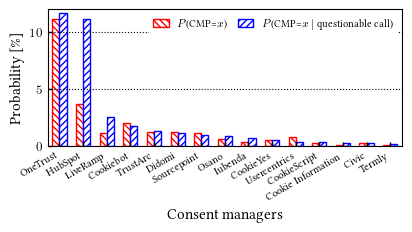

In [13]:
p_cmp_violation_top = p_cmp_x_fp_violation.head(15)
p_cmp_for_top = p_cmp_violation_top.join(p_cmp_x, how="inner", lsuffix="_violation", rsuffix="_total")

df_plot = p_cmp_for_top.rename(columns={ "count_total": P_CMP_X, "count_violation": P_CMP_X_VIOLATION }).iloc[:, ::-1]
df_plot[P_CMP_X] = df_plot[P_CMP_X].apply(lambda value: value*100)
df_plot[P_CMP_X_VIOLATION] = df_plot[P_CMP_X_VIOLATION].apply(lambda value: value*100)
plot = fastplot.plot(
    df_plot,
    path=None,
    mode='bars_multi',
    xlabel='Consent managers', xticks_fontsize="x-small", xticks_rotate=30,
    ylabel='Probability [\\%]', yticks_fontsize="small",
    legend = True, legend_loc='upper right', legend_ncol=4, legend_alpha=1, legend_fontsize="x-small",
    grid_axis="y",
    **PLOT_ARGS
)

for p in plot.gca().patches[:len(df_plot)] + [plot.gca().get_legend().get_patches()[0]]:
    p.set_hatch("\\\\\\\\\\")
    p.set_edgecolor ("red")
    p.set_facecolor ("white")
for p in plot.gca().patches[len(df_plot):] + [plot.gca().get_legend().get_patches()[1]]:
    p.set_hatch("/////")
    p.set_edgecolor ("blue")
    p.set_facecolor ("white")

plot.savefig(f"plots/05_cmp_top_probabilities.pdf")
plot.show()

# Anomalous usage
## Google Tag Manager

In [14]:
has_unauthorized_call = df_clicked.apply(lambda row: any(True for usage in row["second_topics_api_usages"] if getGood2LD(getDomain(usage["context_origin_url"])) not in row["second_allowed_domains"] and getGood2LD(getDomain(usage["context_origin_url"])) == getGood2LD(getDomain(row["domain"]))), axis=1) 
unauthorized_sites = len(df_clicked[has_unauthorized_call])
unauthorized_sites_with_gtm = len(df_clicked[has_unauthorized_call & df_clicked["second_has_gtm"]])

f"Websites with unauthorised call + Google Tag Manager: {unauthorized_sites_with_gtm} [{100 * unauthorized_sites_with_gtm / unauthorized_sites:.2f}% of sites with unauthorised call]"

'Websites with unauthorised call + Google Tag Manager: 2214 [93.26% of sites with unauthorised call]'